C:\Users\Natalka\AppData\Local\Temp\ipykernel_20768\1733078462.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
C:\Users\Natalka\AppData\Local\Temp\ipykernel_20768\1733078462.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
C:\Users\Natalka\AppData\Local\Temp\ipykernel_20768\1733078462.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the r

F1 score: 56.60%
F1 score: 58.14%


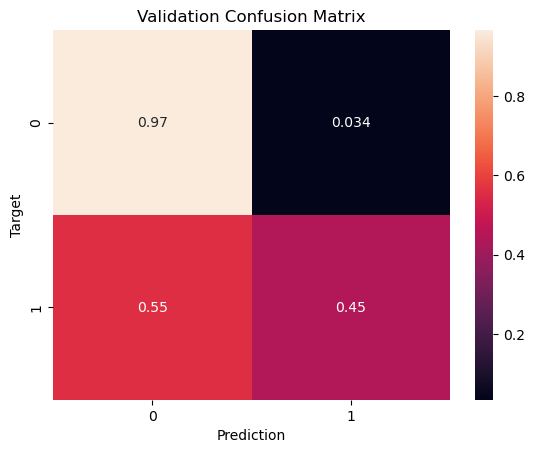

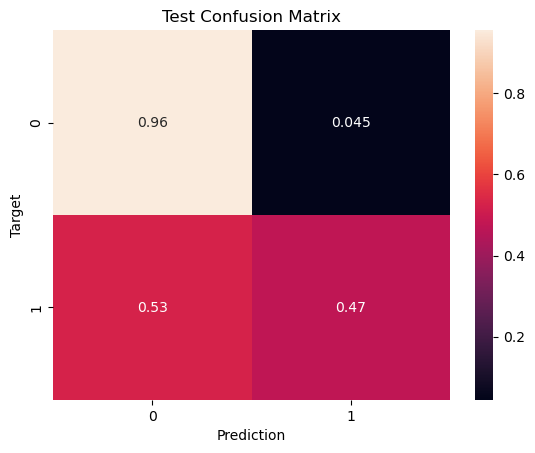

In [32]:

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Download the dataset
raw_df = pd.read_csv('data/weatherAUS.csv.zip')
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

# Create training, validation and test sets
year = pd.to_datetime(raw_df.Date).dt.year
train_df, val_df, test_df = raw_df[year < 2015], raw_df[year == 2015], raw_df[year > 2015]

# Create inputs and targets
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()
test_inputs, test_targets = test_df[input_cols].copy(), test_df[target_col].copy()

# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes( 'object').columns.tolist()

# Impute missing numerical values
imputer = SimpleImputer(strategy = 'mean').fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

# Scale numeric features
scaler = MinMaxScaler().fit(train_inputs[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

# Save processed data to disk
#train_inputs.to_parquet('train_inputs.parquet')
#val_inputs.to_parquet('val_inputs.parquet')
#test_inputs.to_parquet('test_inputs.parquet')
#pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
#pd.DataFrame(val_targets).to_parquet('val_targets.parquet')
#pd.DataFrame(test_targets).to_parquet('test_targets.parquet')

# Load processed data from disk
#train_inputs = pd.read_parquet('train_inputs.parquet')
#val_inputs = pd.read_parquet('val_inputs.parquet')
#test_inputs = pd.read_parquet('test_inputs.parquet')
#train_targets = pd.read_parquet('train_targets.parquet')[target_col]
#val_targets = pd.read_parquet('val_targets.parquet')[target_col]
#test_targets = pd.read_parquet('test_targets.parquet')[target_col]



#Навчання та оцінка моделі
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import joblib

# Select the columns to be used for training/prediction
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# Create and train the model
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, train_targets)

# Helper function to predict, compute accuracy & plot confustion matrix
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    f1 = f1_score(targets, preds, pos_label='Yes')
    print("F1 score: {:.2f}%".format(f1 * 100))
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    return preds

# Evaluate on validation and test set
val_preds = predict_and_plot(X_val, val_targets, 'Validation')
test_preds = predict_and_plot(X_test, test_targets, 'Test')

# Save the trained model & load it back
aussie_rain = {'model': model, 'imputer': imputer, 'scaler': scaler, 'encoder': encoder,
               'input_cols': input_cols, 'target_col': target_col, 'numeric_cols': numeric_cols,
               'categorical_cols': categorical_cols, 'encoded_cols': encoded_cols}
joblib.dump(aussie_rain, 'models/aussie_rain.joblib', compress=('zlib', 3))

import json
from pathlib import Path
feature_df = raw_df.drop(columns=["Date", "RainTomorrow"])
numeric_cols = feature_df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = feature_df.select_dtypes("object").columns.tolist()
meta = {
    "numeric_cols": numeric_cols,
    "categorical_cols": categorical_cols,
    "numeric_stats": {
        col: {
            "min": float(feature_df[col].min()),
            "max": float(feature_df[col].max()),
            "mean": float(feature_df[col].mean()),
        }
        for col in numeric_cols
    },
    "categories": {
        col: sorted(feature_df[col].dropna().unique().tolist())
        for col in categorical_cols
    }
}

Path("assets").mkdir(exist_ok=True)
with open("assets/meta.json", "w") as f:
    json.dump(meta, f, indent=2)